## Introduction
In this kernal we will going through the whole process of creating a AI on the 'mask_detect' dataset. we'll be analyzing, cleaning and visulizing the data in different forms to obtain hidden insights and create an accurate model. Also, if you like it, don't forget to upvote.
the complete project with 97% accuracy is in my github repository(link in profile).

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pkl
import cv2
import os
import seaborn as sns

from plotly import graph_objects as go
from plotly import express as px
from xml.etree import ElementTree as et
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.models import Sequential
from keras.layers.experimental import preprocessing as ps
from keras.layers.experimental import preprocessing as ps
from keras.layers import Activation, Conv2D, BatchNormalization, Dense, Flatten, Dropout, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix

## Preprocess data

In [2]:
data = []
label2category = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
category2label = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}
category2color = {0: (0,255,0), 1: (0,0,255), 2: (0,165,255)}

we put the path and informations of images in a dictionary and we append them to 'data' list

In [3]:
for dir, _, files in os.walk('/kaggle/input/face-mask-detection/annotations'):
    for file_ in files:
        dict_ = dict(img_path=None, objs=[])

        path = os.path.join(dir, file_)
        tree = et.parse(path)
        dict_['img_path'] = os.path.join('/kaggle/input/face-mask-detection/images', tree.find('filename').text)
        for obj in tree.findall('object'):
            label = obj.find('name').text

            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            dict_['objs'].append([xmin, ymin, xmax, ymax, label2category[label]])
        data.append(dict_)

## Images visualization

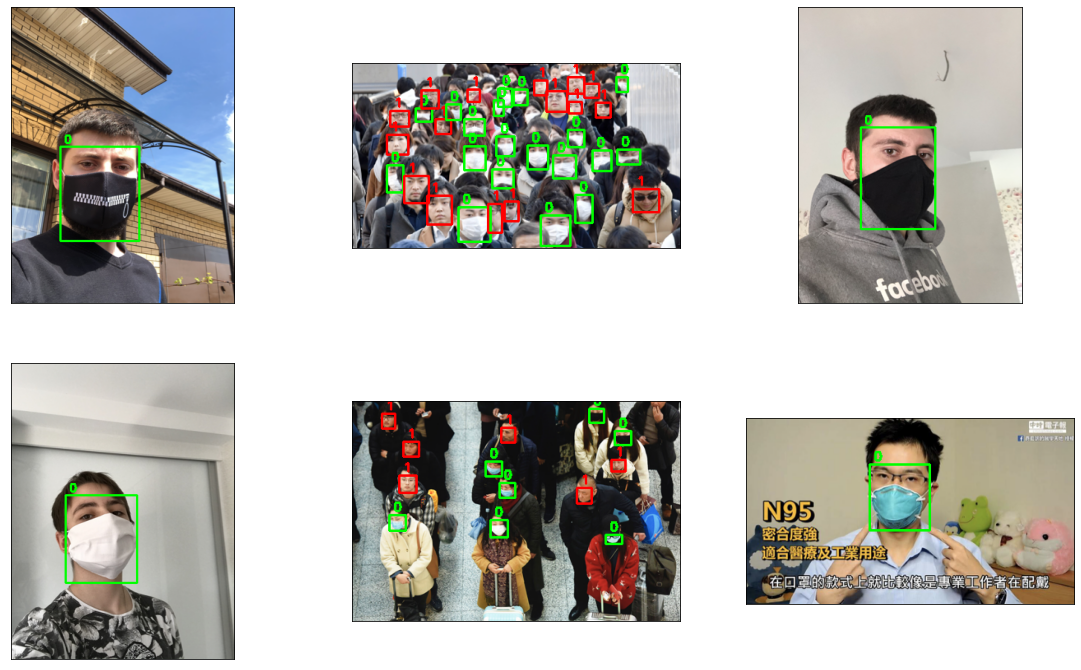

CPU times: user 717 ms, sys: 26.8 ms, total: 744 ms
Wall time: 811 ms


In [4]:
%%time

plt.figure(figsize=(20,12))

for i, _data in enumerate(data[22:28]):
    img = cv2.imread(_data['img_path'])
    for (xmin, ymin, xmax, ymax, label) in _data['objs']:
        cv2.rectangle(img , (xmin, ymin), (xmax, ymax), category2color[label], 2)
        cv2.putText(img, str(label), (xmin+5, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, category2color[label], 2)
    plt.subplot(2,3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

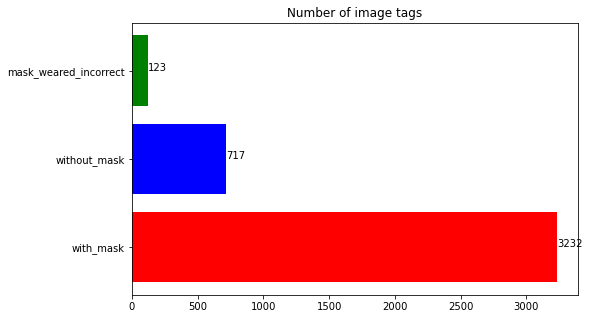

In [5]:
labels = []
for _data in data:
    for (xmin, ymin, xmax, ymax, label) in _data['objs']:
        label = category2label[label]
        labels.append(label)

labels = np.array(labels)
labels_count = Counter(labels)

plt.figure(figsize=(8,5))
plt.title('Number of image tags')

plt.barh(list(labels_count.keys()), list(labels_count.values()), color=['r', 'b', 'g'])
for i,v in enumerate(labels_count.values()):
    plt.text(v, i, str(v))
plt.show()

## Split data

cut only faces at the images

In [6]:
aug_model = Sequential()
aug_model.add(ps.RandomFlip())
aug_model.add(ps.RandomRotation(0.4))

def augment_data(input_img, aument_model, input_label=None, iterate=3):
    img_list = []
    label = []

    label = None
    for _ in range(iterate):
        batch = tf.expand_dims(input_img, 0)
        aug = aug_model(batch)
        img_list.append(np.array(aug[0]))
    return img_list

In [7]:
%%time

x = []
y = []
IMG_SIZE = (64,64)

for _data in data:

  img_path = _data['img_path']
  for (xmin, ymin, xmax, ymax, label) in _data['objs']:
    img = cv2.imread(img_path)
    crop_img = img[ymin : ymax, xmin : xmax]
    re_img = cv2.resize(crop_img, IMG_SIZE)
    re_img = re_img/255
    target = to_categorical(label, num_classes=3)

    if label == 2:
      aug_img = augment_data(re_img, aug_model, iterate=10)
      for aug in aug_img:
        x.append(np.array(aug)); y.append(target)
    elif label == 1:
        aug_img = augment_data(re_img, aug_model, iterate=3)
        for aug in aug_img:
            x.append(np.array(aug)); y.append(target)
    else:
        x.append(re_img); y.append(target)

CPU times: user 1min 24s, sys: 3.06 s, total: 1min 27s
Wall time: 1min 31s


In [8]:
x = np.array(x)
y = np.array(y)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [10]:
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (5290, 64, 64, 3)
x_test shape: (1323, 64, 64, 3)
y_train shape: (5290, 3)
y_test shape: (1323, 3)


In [11]:
def category_convert(data):
    num = []
    for i in range(len(data)):
        num.append(category2label[data[i].argmax()])
    counter = Counter(num)

    return counter

def percent(df):
    _sum = df.sum()
    per = (df/_sum) * 100
    return per

def df_counter(train_counter, test_counter):
    df = pd.DataFrame(columns=['train', 'test'])
    for x in list(train_counter.keys()):
        df.loc[x] = [train_counter[x], test_counter[x]]
    return df

In [12]:
num_train = category_convert(y_train)
num_test = category_convert(y_test)

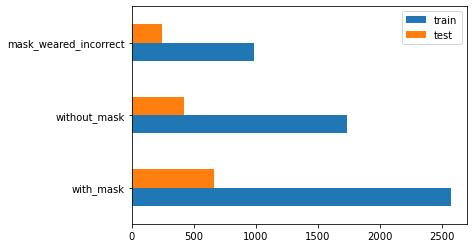

In [13]:
df = df_counter(num_train, num_test)
df.plot(kind='barh')

In [14]:
p_train = percent(df['train'])
p_test = percent(df['test'])

print('in train data:\n with mask: {:.2f} %, without mask: {:.2f} %, mask weared incorrect: {:.2f} %'\
      .format(p_train['with_mask'], p_train['without_mask'], p_train['mask_weared_incorrect']))
print('in test data:\n with mask: {:.2f} %, without mask: {:.2f} %, mask weared incorrect: {:.2f} %'\
      .format(p_test['with_mask'], p_test['without_mask'], p_test['mask_weared_incorrect']))

in train data:
 with mask: 48.56 %, without mask: 32.76 %, mask weared incorrect: 18.68 %
in test data:
 with mask: 50.11 %, without mask: 31.59 %, mask weared incorrect: 18.29 %


## Build our model

In [15]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 128)      

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
CALLBACKS = EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
%%time

EPOCHS = 15

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    callbacks=[CALLBACKS]
)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
yhat = np.argmax(model.predict(x_test), axis=1)
y = np.argmax(y_test, axis=1)

In [ ]:
sns.heatmap(confusion_matrix(yhat, y), annot=True, cmap='rainbow')
plt.ylabel('Predicted output')
plt.xlabel('True output')
plt.show()

## Plot the loss and accurcy of model

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
l = history.history['loss']
val_l = history.history['val_loss']
epoch_len = range(1,len(l)+1)

In [ ]:
# plot the loss

plt.plot(epoch_len, val_l, label='val_loss')
plt.plot(epoch_len, l, label='loss')
plt.xlabel('epoch')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
# plot the accuracy

plt.plot(epoch_len, val_acc, label='val_accuracy')
plt.plot(epoch_len, acc, label='accuracy')
plt.xlabel('epoch')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
## uncomment the code below to save the model
# model.save('Mask_detection_AI.h5')